# Case study: Out-of-distribution generalization

## Task b3: Regression from impulse-response curves (Figure 5)

In [1]:
import sys
sys.path = ['../'] + sys.path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from datetime import datetime

### Auxiliary functions

#### Plotting

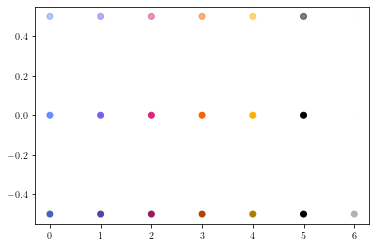

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

# Color palettes
color_blind_1 = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4', '#020202',]
color_blind_2 = ['#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac']
color_blind_3 = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5', '#80cdc1', '#35978f', '#01665e']
ibm_color_blind = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#ffffff"]
rainbow10 = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#7395ff", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a", "#964b00"]


# Pick one and show

palette = ibm_color_blind

base = to_rgb(palette)
basea = to_rgb(palette, a=0.5)
baseb = to_rgb(palette, b=0.7)
plt.scatter(np.arange(len(base)), np.zeros(len(base)), c = base)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, c = basea)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, c = baseb)

#### Custom PyTorch dataset for the impulse-response curves

In [5]:
class TorchImpulseDataset(torch.utils.data.Dataset):
    """
    To load the image datasets.
    """
    
    def __init__(self,impulses,labels,mean_impulses=None,std_impulses=None,mean_labels=None,std_labels=None):
        labels = np.atleast_2d(labels).T
        # Transform labels & impulses into a tensor        
        self.mean_impulses = impulses.mean(axis=0, keepdims=True) if mean_impulses is None else mean_impulses
        self.std_impulses = impulses.std(axis=0, keepdims=True) if std_impulses is None else std_impulses
        self.mean_labels = labels.mean(axis=0, keepdims=True) if mean_labels is None else mean_labels        
        self.std_labels = labels.std(axis=0, keepdims=True) if std_labels is None else std_labels
            
        self.impulses = torch.tensor((impulses - self.mean_impulses) / self.std_impulses, dtype=torch.float32)
        self.labels = torch.tensor((labels - self.mean_labels) / self.std_labels, dtype=torch.float32)
        if len(impulses) != len(labels):
            raise ValueError("Labels and impulses must have the same length!")
        else:
            self.n = len(impulses)
        

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.impulses[idx], self.labels[idx]

### Download and visualize dataset

In [6]:
import causalchamber.datasets as datasets
datasets.directory
impulse_dataset = datasets.Dataset(name="wt_intake_impulse_v1", root="/tmp")
impulse_dataset.available_experiments()


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or models for your work please consider citing:

@article{gamella2024chamber,
  title={The Causal Chambers: Real Physical Systems as a Testbed for AI Methodology},
  author={Gamella, Juan L. and B"uhlmann, Peter and Peters, Jonas},
  journal={arXiv preprint arXiv:2404.11341},
  year={2024}
}




100%|██████████| 51.3M/51.3M [00:04<00:00, 11.0MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.


['load_out_0.01_osr_downwind_4',
 'load_out_1_osr_downwind_4',
 'load_out_0.5_osr_downwind_8',
 'load_out_0.5_osr_downwind_2',
 'load_out_0.5_osr_downwind_4']

In [7]:
# To extract impulses into a new dataframe with one row per impulse
def extract_impulses(df_raw, field="pressure_downwind"):
    len_impulse = len(df_raw[df_raw.flag == 0])
    n_impulses = len(pd.unique(df_raw.flag))
    impulses = df_raw[field].values.reshape(n_impulses,len_impulse)
    params = df_raw.loc[0::50][['hatch', 'load_out', 'osr_downwind']].values
    array = np.hstack([params, impulses])
    return pd.DataFrame(array, columns=["hatch", "load_out", "osr_downwind"] + ["t_%d" % i for i in range(len_impulse)])

#### load_out = 0.5, osr = 4

In [8]:
df_l05_o4 = extract_impulses(impulse_dataset.get_experiment('load_out_0.5_osr_downwind_4').as_pandas_dataframe())

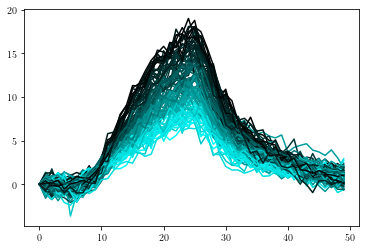

In [9]:
for _,row in df_l05_o4.iloc[0:100].iterrows():    
    hatch = row.hatch
    load_out = row.load_out    
    impulse = row.values[3:]
    plt.plot(impulse - impulse[0], color=np.array([0,1,1]) * hatch / 45)

#### load_out = 1, osr = 4

In [14]:
df_l1_o4 = extract_impulses(impulse_dataset.get_experiment('load_out_1_osr_downwind_4').as_pandas_dataframe())

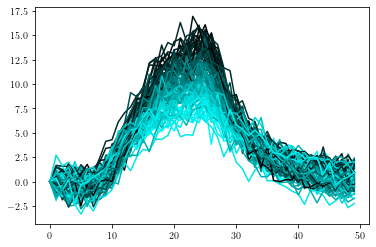

In [15]:
for _,row in df_l1_o4.iloc[0:100].iterrows():    
    hatch = row.hatch
    load_out = row.load_out    
    impulse = row.values[3:]
    plt.plot(impulse - impulse[0], color=np.array([0,1,1]) * hatch / 45)

#### load_out = 0.01, osr = 4

In [16]:
df_l001_o4 = extract_impulses(impulse_dataset.get_experiment('load_out_0.01_osr_downwind_4').as_pandas_dataframe())

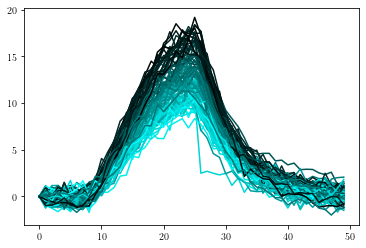

In [17]:
for _,row in df_l001_o4.iloc[0:100].iterrows():    
    hatch = row.hatch
    load_out = row.load_out    
    impulse = row.values[3:]
    plt.plot(impulse - impulse[0], color=np.array([0,1,1]) * hatch / 45)

#### load_out = 0.5, osr = 2

In [18]:
df_l05_o2 = extract_impulses(impulse_dataset.get_experiment('load_out_0.5_osr_downwind_2').as_pandas_dataframe())

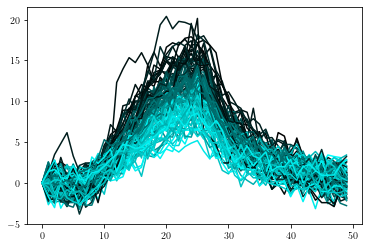

In [19]:
for _,row in df_l05_o2.iloc[0:100].iterrows():    
    hatch = row.hatch
    load_out = row.load_out    
    impulse = row.values[3:]
    plt.plot(impulse - impulse[0], color=np.array([0,1,1]) * hatch / 45)

#### load_out = 0.5, osr = 8

In [20]:
df_l05_o8 = extract_impulses(impulse_dataset.get_experiment('load_out_0.5_osr_downwind_8').as_pandas_dataframe())

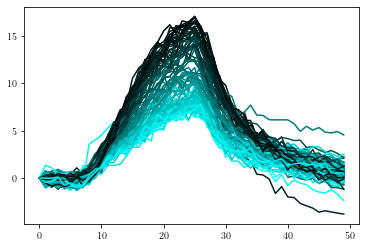

In [21]:
for _,row in df_l05_o8.iloc[0:100].iterrows():    
    hatch = row.hatch
    load_out = row.load_out    
    impulse = row.values[3:]
    plt.plot(impulse - impulse[0], color=np.array([0,1,1]) * hatch / 45)

#### upwind barometer load_out = 0.5, osr = 8

In [22]:
df_upwind = extract_impulses(impulse_dataset.get_experiment('load_out_0.5_osr_downwind_8').as_pandas_dataframe(), 'pressure_upwind')

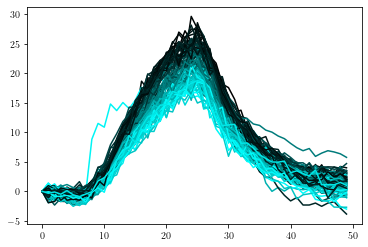

In [23]:
for _,row in df_upwind.iloc[0:100].iterrows():    
    hatch = row.hatch
    load_out = row.load_out    
    impulse = row.values[3:]    
    plt.plot(impulse - impulse[0], color=np.array([0,1,1]) * hatch / 45)

### Split into train / test / validation sets and standardize

We will use the data as follows:

- training set:  experiment `wt_intake_impulse_load_out_0.5_osr_downwind_4`
- validation sets: experiments
    - lower exhaust_load: `wt_intake_impulse_load_out_0.01_osr_downwind_4`
    - higher exhaust load: `wt_intake_impulse_load_out_1_osr_downwind_4`
    - lower precision: `wt_intake_impulse_load_out_0.5_osr_downwind_2`
    - higher precision: `wt_intake_impulse_load_out_0.5_osr_downwind_8`
    - different barometer ($\tilde{P}_\text{up}$): `wt_intake_impulse_load_out_0.5_osr_downwind_2`

In [24]:
n_validate = 900
n_test = 100
Ns = [4000]
datasets = {}
for n in Ns:
    print(n)
    df_train = df_l05_o4.sample(n=n, random_state=1)
    df_rest = df_l05_o4.drop(df_train.index)
    df_test = df_rest.sample(n=n_test, random_state=2)
    df_rest = df_rest.drop(df_test.index)
    df_validate_train = df_rest.sample(n=n_validate, random_state=3)
    # Cast into torch dataset and normalize
    dataset_train = TorchImpulseDataset(df_train.values[:,3:], df_train.hatch.values)
    standardization = {'mean_impulses': dataset_train.mean_impulses,
                       'std_impulses': dataset_train.std_impulses,
                       'mean_labels': dataset_train.mean_labels,
                       'std_labels': dataset_train.std_labels}    
    # Training dataset
    datasets[n] = {}
    datasets[n]['train'] = dataset_train
    # Test dataset
    datasets[n]['test'] = TorchImpulseDataset(df_test.values[:,3:], df_test.hatch.values, **standardization)
    # Validation datasets
    datasets[n]['validate'] = TorchImpulseDataset(df_validate_train.values[:,3:], df_validate_train.hatch.values, **standardization)
    # Lower load
    df = df_l001_o4.sample(n = n_validate, random_state=4)
    datasets[n]['load_out = 0.01'] = TorchImpulseDataset(df.values[:,3:], df.hatch.values, **standardization)
    # Higher load
    df = df_l1_o4.sample(n = n_validate, random_state=4)
    datasets[n]['load_out = 1'] = TorchImpulseDataset(df.values[:,3:], df.hatch.values, **standardization)
    # Lower precision
    df = df_l05_o2.sample(n = n_validate, random_state=5)
    datasets[n]['osr = 2'] = TorchImpulseDataset(df.values[:,3:], df.hatch.values, **standardization)
    # Higher precision
    df = df_l05_o8.sample(n = n_validate, random_state=5)
    datasets[n]['osr = 8'] = TorchImpulseDataset(df.values[:,3:], df.hatch.values, **standardization)
    # Different barometer
    df = df_upwind.sample(n = n_validate, random_state=5)
    datasets[n]['upwind'] = TorchImpulseDataset(df.values[:,3:], df.hatch.values, **standardization)

4000


### Train or load models

In [25]:
train = False

In [26]:
from torch.utils.data import DataLoader
import time
def train_model(model, dataset_train, dataset_test, epochs=200, batch_size=128,learning_rate=1e-3, weight_decay=1e-5, device="cuda",every=15):    
    print("Device: %s" % device, " batch size:", batch_size)    

    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam
    opt_args = {'lr': learning_rate, 'weight_decay': weight_decay}    

    # Dataloaders
    dataloader_args = {'shuffle': True, 'num_workers':0}
    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, **dataloader_args)
    X_test, Y_test = next(iter(DataLoader(dataset_test, batch_size=len(dataset_test))))

    # Initiate optimizer
    optimizer = optimizer(model.parameters(), **opt_args)

    # Training loop
    for epoch in range(epochs):
        start = time.time()
        print(f"\nEpoch {epoch}") if epoch % every == 0 else None
        for i,(X,Y) in enumerate(train_dataloader):            

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(X)
            # Compute the loss
            loss = loss_function(y_pred, Y.to(device))

            # Zero gradients, backward pass, and update weights

            loss.backward()
            optimizer.step()

            # Compute test loss        
            y_pred_test = model(X_test)
            test_loss = loss_function(y_pred_test, Y_test.to(device)).item()
        elapsed = time.time() - start
        # Print progress every 100 epochs
        if epoch % every == 0:
            print(f"Epoch {epoch}, {elapsed:0.1f} seconds , Loss: {loss.item()}, Test loss: {test_loss}")
            
    return model

In [28]:
fitted_models = dict((n,[]) for n in Ns)
seeds = np.arange(16)
for seed in seeds:
    torch.manual_seed(seed)
    from src.models import MLP
    torch.cuda.empty_cache()    
    layers = [200,200]
    for n in Ns:        
        print("\n\n\nn =", n)
        path = f"torch_models/mlp_" + "_hatch_layers_" + "_".join([str(l) for l in layers]) + f"_n_{n}_seed_{seed}.pkl"
        if train:
            model = MLP(50, 1, layers, device="cuda")
            model = train_model(model, datasets[n]['train'], datasets[n]['test'], batch_size=1024)
            torch.save(model.state_dict(), path)
            print(f'Saved model to "{path}"')
        else:
            model = MLP(50, 1, layers, device="cuda")
            model.load(path)
        fitted_models[n].append(model)




n = 4000



n = 4000



n = 4000



n = 4000



n = 4000



n = 4000



n = 4000



n = 4000



n = 4000



n = 4000



n = 4000



n = 4000



n = 4000



n = 4000



n = 4000



n = 4000


### Compute MAE

In [29]:
def denormalize(x,n):
    means = datasets[n]['train'].mean_labels[0][0]
    stds = datasets[n]['train'].std_labels[0][0]
    return stds * x + means
    

In [30]:
MAEs = np.zeros((len(Ns), len(datasets[Ns[0]]), len(seeds)))
dataset_names = datasets[Ns[0]].keys()
indices = dict(zip(dataset_names, np.arange(len(dataset_names))))
with torch.no_grad():    
    for i,n in enumerate(Ns):        
        for key,dataset in datasets[n].items():
            for k,model in enumerate(fitted_models[n]):
                impulses, truths = next(iter(DataLoader(dataset, batch_size=len(dataset))))
                truths = denormalize(truths.numpy(), n)            
                pred = model(impulses).detach().cpu().numpy()
                pred = denormalize(pred,n)            
                mae = (abs(pred - truths)).sum() / len(dataset)            
                MAEs[i,indices[key],k] = mae

In [38]:
MAEs_mean = np.zeros((len(Ns), len(datasets[Ns[0]]), len(seeds)))
# Compute mean of training dataset
mean = df_train.hatch.mean()
for i,n in enumerate(Ns):            
    print(mean)
    for key,dataset in datasets[n].items():
        for k,model in enumerate(fitted_models[n]):
            impulses, truths = next(iter(DataLoader(dataset, batch_size=len(dataset))))
            truths = denormalize(truths.numpy(), n)            
            pred = mean            
            mae = (abs(pred - truths)).sum() / len(dataset)            
            MAEs_mean[i,indices[key],k] = mae

22.3733531075418


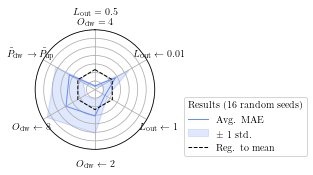

In [42]:
# Taken from https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
mmax = 34

plt.figure(figsize=(2.2,2.2))

def t(x):
    return x
    return np.power(x, 1/3)
    
# ------- PART 1: Create background
 
# number of variables

labels = {'validate': r'$L_\text{out} = 0.5$' + '\n' + r'$O_\text{dw} = 4$',
          'load_out = 0.01': r'$L_\text{out} \leftarrow 0.01$',
          'load_out = 1': r'$L_\text{out} \leftarrow 1$',
          'osr = 2': r'$O_\text{dw} \leftarrow 2$',
          'osr = 8': r'$O_\text{dw} \leftarrow 8$',
          'upwind': r'$\tilde{P}_{\text{dw}} \to \tilde{P}_{\text{up}}$',
         }
categories=[name for _,name in enumerate(dataset_names) if name not in ['test', 'train']]
categories = [labels[c] for c in categories]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
yticks = np.linspace(0,mmax,8)
plt.yticks(t(yticks), [])
plt.ylim(0,t(mmax))
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data

#

idx=[i for i,name in enumerate(dataset_names) if name not in ['test', 'train']]
i=0
n = Ns[0]
mean = t(MAEs[0,idx,:].mean(axis=1))
mean = np.array(list(mean) + [mean[0]])
std = t(MAEs[0,idx,:].std(axis=1))
std = np.array(list(std) + [std[0]])

ax.plot(angles, mean, linewidth=1, linestyle='solid', color = base[i], label="Avg. MAE")
ax.plot(angles, mean+std, linewidth=0.1, linestyle='-', color = base[i])
ax.plot(angles, mean-std, linewidth=0.1, linestyle='-', color = base[i])
#ax.fill(angles, values, color=base[i]*np.array([1,1,1,0.2]))
ax.fill_between(angles, mean+std, mean-std, color=base[i]*np.array([1,1,1,0.2]), label="$\pm$ 1 std.")

# Reg. to the mean
mean = t(MAEs_mean[i,2:,:].mean(axis=1))
mean = np.array(list(mean) + [mean[0]])
std = t(MAEs_mean[i,2:,:].std(axis=1))
std = np.array(list(std) + [std[0]])
i=5
ax.plot(angles, mean, linewidth=1, linestyle='--', color = base[i], label = "Reg. to mean")
#ax.fill(angles, values, color=base[i]*np.array([1,1,1,0.2]))
#ax.fill_between(angles, mean+std, np.maximum(0,mean-std), color=base[i]*np.array([1,1,1,0.2]),label = "$\pm$ 1 std.")


# Add legend
legend = plt.legend(loc='lower left', bbox_to_anchor=(1.2, -0.1), title="Results (16 random seeds)")
legend._legend_box.align = "left"

# Show the graph
plt.savefig(f"../figures/impulse_regression_n_{n}.pdf", bbox_inches="tight", transparent="True")

### Additional plot for the figure

In [ ]:
df = extract_impulses(impulse_dataset.get_experiment('wt_intake_impulse_load_out_0.5_osr_downwind_8').as_pandas_dataframe())

In [ ]:
hatches = [sorted(pd.unique(df.hatch))[i] for i in [0,100,200,300,400]]

In [ ]:
plt.figure(figsize=(2,4))
for i,h in enumerate(hatches):
    row = df[df.hatch==h].iloc[0]
    impulse = row.values[3:] - row.values[-1] 
    plt.plot((impulse / 15)-1.2*i,color='black')
    #plt.text(49, -i*1.2+0.1, r"$X := \tilde{P}^t_\text{dw}$")
    plt.text(30, -i*1.2+0.5, "$H = %d$" % h, fontsize=16)

plt.xticks(np.arange(6)*10,[])
plt.xlabel("$t$", fontsize=12)
plt.yticks([],[])
#plt.xticks(np.arange(6)*10,[])
#plt.yticks(-np.arange(len(hatches))*1.2)
plt.savefig(f"../figures/impulse_curves.pdf", bbox_inches="tight", transparent="True")